In [1]:
import os
# os.chdir("/home/user/Documents/projects/openclip")
os.chdir("/home/zhuoyan/vision/openclip")
import numpy as np
from collections import defaultdict 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# data_path = "/home/user/Documents/projects/openclip/eval_log"
data_path = "/home/zhuoyan/vision/openclip/eval_log"
import json
import time 

# Function to load JSON data from a file
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

In [2]:

data = load_json(f"{data_path}/baseline_results_128branch_10SamplePerClass.json")
df = pd.DataFrame(data)
df.rename(columns={'imagenet-zeroshot-val-top1': 'accs'}, inplace=True)

In [3]:
df.head()

,accs,imagenet-zeroshot-val-top5,macs
0,0.0013,0.0065,0.513097
1,0.0016,0.0080,0.431947
2,0.0116,0.0402,0.675398
3,0.2999,0.5737,0.837699
4,0.0024,0.0088,0.513097


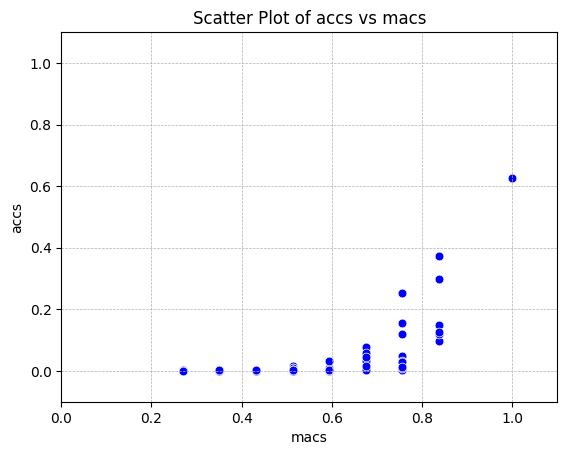

In [4]:
df = df.sort_values(by='macs', ascending=True)
# Using Seaborn to plot
sns.scatterplot(data=df, x='macs', y='accs', color='blue', s=40)

plt.xlim(0, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Scatter Plot of accs vs macs')
plt.show()

In [5]:
# Define the range width for 'macs', e.g., 0.05 for 5% intervals
bin_width = 0.01
max_points = []

# Iterate over the 'macs' range using the bin size
for bin_start in np.arange(0, 1, bin_width):
    # Find all points within the current bin range
    
    bin_end = bin_start + bin_width
    # print(bin_start, bin_end)
    bin_df = df[(df['macs'] >= bin_start) & (df['macs'] <= bin_end)]
    
    # If there are points in the bin, select the one with the maximum 'accs'
    if not bin_df.empty:
        max_point = bin_df.loc[bin_df['accs'].idxmax()]
        max_points.append(max_point)

saved_points = []
for item in max_points:
    point_dict = item.to_dict()  # Convert Series to dict
    point_dict['Name'] = item.name  # Add the 'Name' which is the index of the Series
    saved_points.append(point_dict)


In [6]:
up = [0,128]  ## saved the acc and branch name
tabled_points = []
for dic in saved_points:
    if dic['accs'] >= up[0]:
        up[0] = dic['accs']
        up[1] = dic['Name']
        tabled_points.append(dic)
    else:
        dic['accs']= up[0]

In [7]:
df['ckpt'] = 'baseline'

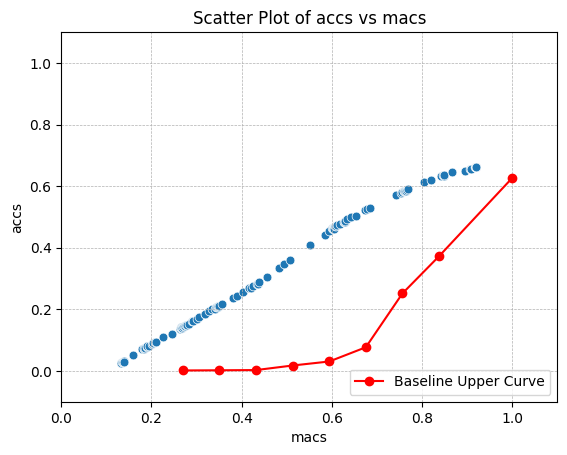

In [15]:
# Convert the list of points to a DataFrame
upper_curve_df = pd.DataFrame(saved_points)

# Using Seaborn to plot the scatter plot
sns.scatterplot(data=df, x='macs', y='accs',  s=40)

# Plotting the manually selected upper curve
plt.plot(upper_curve_df['macs'], upper_curve_df['accs'], color='red', label='Baseline Upper Curve', marker='o')

# Set the limits, grid, and title as before
plt.xlim(0, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Scatter Plot of accs vs macs')

# Add the legend with the location set to bottom right
plt.legend(loc='lower right')

# Display the plot
plt.show()

In [16]:
# data = load_json(f"{data_path}/eval_results_128latency_10SamplePerClass.json")
data = load_json(f"{data_path}/eval_results_128latency_lora.json")
df = pd.DataFrame(data)
df.rename(columns={'imagenet-zeroshot-val-top1': 'accs'}, inplace=True)

In [17]:
df.head()

,accs,imagenet-zeroshot-val-top5,macs_diff,latency,macs
0,0.0265,0.0737,0.023379,0.110926,0.131804
1,0.0267,0.0758,0.023329,0.111804,0.132031
2,0.0252,0.0719,0.022724,0.112799,0.131706
3,0.0264,0.0784,0.021227,0.121764,0.133159
4,0.0292,0.0836,0.017018,0.137346,0.134335


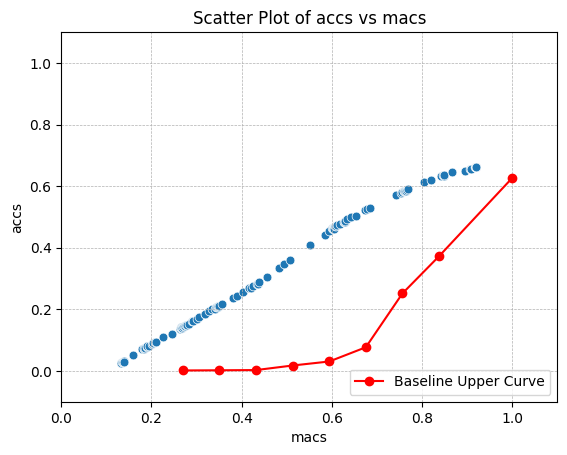

In [19]:
# Using Seaborn to plot the scatter plot
sns.scatterplot(data=df, x='macs', y='accs',  s=40)

# Plotting the manually selected upper curve
plt.plot(upper_curve_df['macs'], upper_curve_df['accs'], color='red', label='Baseline Upper Curve', marker='o')

# Set the limits, grid, and title as before
plt.xlim(0, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Scatter Plot of accs vs macs')

# Add the legend with the location set to bottom right
plt.legend(loc='lower right')

# Display the plot
plt.show()